<a href="https://colab.research.google.com/github/Khotso-Bore/neural-languange-model/blob/Fine-Tuning/AfroXLMR_NLPkkk_(2)_(1)_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression





In [3]:

sesotho_url = 'https://raw.githubusercontent.com/Khotso-Bore/neural-languange-model/refs/heads/main/sesotho_tweets.csv'

so_df = pd.read_csv(sesotho_url)

In [4]:
# Read the text file
with open('/content/NewsSA.txt', 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]

# Pair text with labels (every odd line is text, even is label)
data = []
for i in range(0, len(lines), 2):
    text = lines[i]
    label = int(lines[i+1])
    data.append({'sentence': text, 'label': label})

# Create DataFrame
newS_df = pd.DataFrame(data)
print(newS_df.head())

                                            sentence  label
0  BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...     -1
1                     TSEBA MARENA A SEHLOOHO A NAHA      0
2       LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO     -1
3  MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA     -1
4  LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...     -1


In [5]:
so_df.head()

,sentence,Final_labels,predict_name
0,@user gwa tshwana rena ba bang a re kreye selo...,negative,Sesotho
1,e bata goal spurs,neutral,Sesotho
2,@user @user ke nahana taba eno ea ho batla ho ...,negative,multi
3,@user lotho hle empa fela ke ipotela,positive,Sesotho
4,@user @user keu utloa hantle,positive,Sesotho


In [6]:
so_df.value_counts

<bound method DataFrame.value_counts of                                                sentence Final_labels  \
0     @user gwa tshwana rena ba bang a re kreye selo...     negative   
1                                     e bata goal spurs      neutral   
2     @user @user ke nahana taba eno ea ho batla ho ...     negative   
3                  @user lotho hle empa fela ke ipotela     positive   
4                          @user @user keu utloa hantle     positive   
...                                                 ...          ...   
2995  @user @user ntho diqala jwalo rumoursthe knes ...     negative   
2996  @user iΓö£┬╗Γö¼Γò£m on leave ntse ke sheba hen...     negative   
2997  he must come to botswana a re thuse that bogus...     negative   
2998  @user wa bona ea hlokomela something fishy moh...     negative   
2999  @user ebe ulto etsang ngoaneso with the traffi...     negative   

     predict_name  
0         Sesotho  
1         Sesotho  
2           multi  
3         Sesotho  
4         Sesotho  
...           ...  
2995      Sesotho  
2996      Sesotho  
2997        multi  
2998      Sesotho  
2999      Sesotho  

[3000 rows x 3 columns]>

In [7]:
def clean_tweets(text):
    if pd.isnull(text):
        return ""

    # Remove mentions, URLs, hashtags, digits (keep diacritics)
    text = re.sub(r'@\w+|https?\S+|www\S+|#|\d+', '', text)

    # Keep Sesotho punctuation (e.g., "’") but remove others
    text = re.sub(r'[^\w\s’]', '', text)

    #remove URLs
    text = re.sub(r'https\S+|www\S+', '', text)

    #Remove Hashtags
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits (optional)
    text = re.sub(r'\d+', '', text)

    # Remove emojis (optional)
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove emojis using regex
    text = re.sub(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002700-\U000027BF"  # other symbols
        u"\U000024C2-\U0001F251"  # enclosed characters
        "]+",
        repl='',
        string=text,
        flags=re.UNICODE
    )


    # Remove extra whitespace (keep lowercase)
    return re.sub(r'\s+', ' ', text).strip().lower()





In [8]:
# Apply the same cleaning function used for so_df
newS_df['cleaned_sent'] = newS_df['sentence'].apply(clean_tweets)  # Your existing clean_tweets() function

In [9]:
newS_df.head()

,sentence,label,cleaned_sent
0,BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...,-1,basuoe ba qosuoe ka pelaelo ea ho bolaea moshe...
1,TSEBA MARENA A SEHLOOHO A NAHA,0,tseba marena a sehlooho a naha
2,LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO,-1,lintlhakholo mabapi le ntlo e oetseng batho
3,MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA,-1,motho o khaotsoe botona le menoana a ntse a phela
4,LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...,-1,litaba tse bohloko ho maqheku le maqhekoana na...


In [10]:
so_df['cleaned_sent']= so_df['sentence'].apply(clean_tweets)
so_df.head()

,sentence,Final_labels,predict_name,cleaned_sent
0,@user gwa tshwana rena ba bang a re kreye selo...,negative,Sesotho,gwa tshwana rena ba bang a re kreye selo mos
1,e bata goal spurs,neutral,Sesotho,e bata goal spurs
2,@user @user ke nahana taba eno ea ho batla ho ...,negative,multi,ke nahana taba eno ea ho batla ho khetha hoban...
3,@user lotho hle empa fela ke ipotela,positive,Sesotho,lotho hle empa fela ke ipotela
4,@user @user keu utloa hantle,positive,Sesotho,keu utloa hantle


In [11]:
# Rename column for consistency and map labels
so_df.rename(columns={'Final_labels': 'label'}, inplace=True)
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
so_df['label'] = so_df['label'].map(label_map)

# Verify label distribution
print(so_df['label'].value_counts())

label
1    1464
0     953
2     583
Name: count, dtype: int64


In [12]:
print(so_df.columns)

Index(['sentence', 'label', 'predict_name', 'cleaned_sent'], dtype='object')


In [13]:
so_df.head()

,sentence,label,predict_name,cleaned_sent
0,@user gwa tshwana rena ba bang a re kreye selo...,1,Sesotho,gwa tshwana rena ba bang a re kreye selo mos
1,e bata goal spurs,2,Sesotho,e bata goal spurs
2,@user @user ke nahana taba eno ea ho batla ho ...,1,multi,ke nahana taba eno ea ho batla ho khetha hoban...
3,@user lotho hle empa fela ke ipotela,0,Sesotho,lotho hle empa fela ke ipotela
4,@user @user keu utloa hantle,0,Sesotho,keu utloa hantle


In [14]:

sesotho_df = pd.concat([
    so_df[['cleaned_sent', 'label', 'predict_name']],
    newS_df[['cleaned_sent', 'label']].assign(predict_name='Sesotho')
], ignore_index=True)

# Verify
print("Original:", len(so_df), "New:", len(newS_df), "Combined:", len(sesotho_df))
print("\nLabel counts:")
print(sesotho_df['label'].value_counts())
print("\nColumns in final DataFrame:", sesotho_df.columns.tolist())

Original: 3000 New: 2209 Combined: 5209

Label counts:
label
 1    2015
-1    1552
 0    1059
 2     583
Name: count, dtype: int64

Columns in final DataFrame: ['cleaned_sent', 'label', 'predict_name']


In [15]:
# Replace -1 with 1 in the 'label' column
sesotho_df['label'] = sesotho_df['label'].replace({-1: 1})

# Verify
print(sesotho_df['label'].value_counts())

label
1    3567
0    1059
2     583
Name: count, dtype: int64


In [16]:
print(sesotho_df.isnull().sum())

cleaned_sent    0
label           0
predict_name    0
dtype: int64


In [17]:
sesotho_df.head()

,cleaned_sent,label,predict_name
0,gwa tshwana rena ba bang a re kreye selo mos,1,Sesotho
1,e bata goal spurs,2,Sesotho
2,ke nahana taba eno ea ho batla ho khetha hoban...,1,multi
3,lotho hle empa fela ke ipotela,0,Sesotho
4,keu utloa hantle,0,Sesotho


In [18]:
# print(ts_df.isnull().sum())
print(sesotho_df.isnull().sum())


cleaned_sent    0
label           0
predict_name    0
dtype: int64


In [19]:
# ts_df['predict_name'].fillna('unknown', inplace=True)
sesotho_df['predict_name'].fillna('Sesotho', inplace=True)


<ipython-input-19-1871654108>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sesotho_df['predict_name'].fillna('Sesotho', inplace=True)


In [20]:
# print(ts_df.isnull().sum())
print(sesotho_df.isnull().sum())


cleaned_sent    0
label           0
predict_name    0
dtype: int64


In [21]:

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=sesotho_df['label'].values  # Make sure this is a 1D NumPy array
)

print("\nClass Weights (for balancing):")
print(f"Positive (0): {class_weights[0]:.2f}")
print(f"Negative (1): {class_weights[1]:.2f}")
print(f"Neutral (2): {class_weights[2]:.2f}")


Class Weights (for balancing):
Positive (0): 1.64
Negative (1): 0.49
Neutral (2): 2.98


In [22]:
print(sesotho_df['label'].value_counts())

label
1    3567
0    1059
2     583
Name: count, dtype: int64


In [23]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    sesotho_df['cleaned_sent'], sesotho_df['label'], test_size=0.2, random_state=42
)

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-large")

# Tokenize datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [25]:
import torch

class SesothoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SesothoDataset(train_encodings, train_labels)
test_dataset = SesothoDataset(test_encodings, test_labels)

In [26]:
from torch import nn
import torch

# # 1. Compute your class weights (as before)
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.array([0, 1, 2]),
#     y=sesotho_df['label'].values
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # Convert to tensor

# 2. Create a custom Trainer class
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=weights)  # Apply your weights here
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [28]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import os
os.environ["WANDB_DISABLED"] = "true"  # Blocks wandb at system level

model = AutoModelForSequenceClassification.from_pretrained(
    "Davlan/afro-xlmr-large", num_labels=3
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=4,  # Reduced from 8
    learning_rate=5e-6,  # Lowered from 2e-5
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy= 'epoch',
    eval_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end= True,
    metric_for_best_model='accuracy',
    report_to="none"

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.995400,0.712688,0.692898,0.709663,0.692898,0.631218
2,0.594900,0.688637,0.690019,0.687369,0.690019,0.688646
3,0.425900,0.755558,0.722649,0.691677,0.722649,0.693560
4,0.562300,0.734963,0.704415,0.709278,0.704415,0.700797


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.995400,0.712688,0.692898,0.709663,0.692898,0.631218
2,0.594900,0.688637,0.690019,0.687369,0.690019,0.688646
3,0.425900,0.755558,0.722649,0.691677,0.722649,0.693560
4,0.562300,0.734963,0.704415,0.709278,0.704415,0.700797
5,0.511400,0.784696,0.729367,0.708459,0.729367,0.714545


TrainOutput(global_step=5210, training_loss=0.6617300056907814, metrics={'train_runtime': 3727.4463, 'train_samples_per_second': 5.59, 'train_steps_per_second': 1.398, 'total_flos': 3488966233471080.0, 'train_loss': 0.6617300056907814, 'epoch': 5.0})

In [29]:
model.save_pretrained("./sesotho_sentiment_model")
tokenizer.save_pretrained("./sesotho_sentiment_model")

('./sesotho_sentiment_model/tokenizer_config.json',
 './sesotho_sentiment_model/special_tokens_map.json',
 './sesotho_sentiment_model/sentencepiece.bpe.model',
 './sesotho_sentiment_model/added_tokens.json',
 './sesotho_sentiment_model/tokenizer.json')

In [39]:

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# True labels
true_labels = test_labels.tolist()  # Convert to list if needed

In [41]:
# Calculate prediction probabilities and identify uncertain samples
probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)
probs_np = probs.numpy()  # Convert once for clarity
uncertain_samples = np.where(np.max(probs_np, axis=1) < 0.7)[0]  # Confidence <70%

# Inspect uncertain samples
print(f"Found {len(uncertain_samples)} low-confidence predictions:")
for idx in uncertain_samples[:5]:  # Print first 5 uncertain examples
    print(f"\nText: {test_texts.iloc[idx]}")
    print(f"True Label: {list(label_map.keys())[true_labels[idx]]}")
    print(f"Predicted: {list(label_map.keys())[preds[idx]]} (Confidence: {np.max(probs_np[idx]):.2f})")

Found 223 low-confidence predictions:

Text: kore hake nahana your daughters will be sending my son nudes
True Label: neutral
Predicted: negative (Confidence: 0.68)

Text: william sejake and lebo sekgobelas rendition of morena oba etele remains my favouritebophelo ke wena fela empa batho ha ba tsebeba lahlehetswe ke tsela ba kgelositswe ke sebetadima bomadimabe joa ba sa tsebeng thapeloo ba romele diabi tsa ditaba tsa bophelo
True Label: positive
Predicted: negative (Confidence: 0.60)

Text: ba sekgoa sa bo hey you boy ba tla nama ba re emetse hantle ko tla ba zamela show nyana ko notwane
True Label: positive
Predicted: negative (Confidence: 0.53)

Text: mosebetsi hase lefa maan
True Label: negative
Predicted: positive (Confidence: 0.59)

Text: mara banna ba le etsang
True Label: positive
Predicted: negative (Confidence: 0.48)


Classification Report:
              precision    recall  f1-score   support

    positive       0.47      0.41      0.44       205
    negative       0.81      0.88      0.84       725
     neutral       0.51      0.31      0.39       112

    accuracy                           0.73      1042
   macro avg       0.60      0.54      0.56      1042
weighted avg       0.71      0.73      0.71      1042

Accuracy: 0.7294
Weighted F1: 0.7145
Macro F1: 0.5568


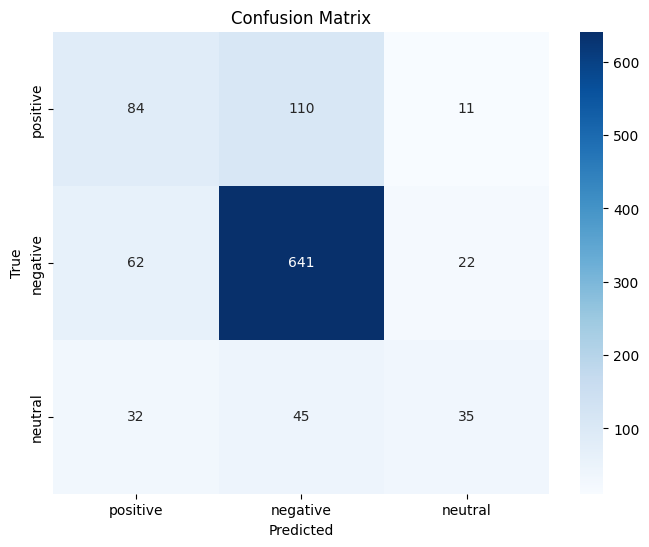

In [42]:
# Classification Report (includes F1, precision, recall per class + accuracy)
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=list(label_map.keys())))

# Individual Metrics
print(f"Accuracy: {accuracy_score(true_labels, preds):.4f}")
print(f"Weighted F1: {f1_score(true_labels, preds, average='weighted'):.4f}")
print(f"Macro F1: {f1_score(true_labels, preds, average='macro'):.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

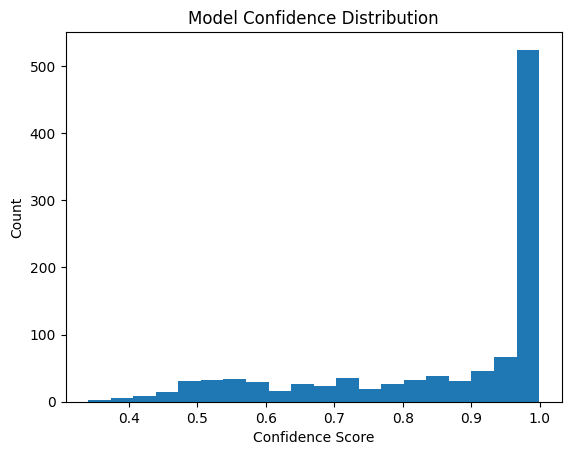

In [43]:
plt.hist(np.max(probs.numpy(), axis=1), bins=20)
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.title("Model Confidence Distribution")
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC AUC (only for binary/multiclass)
if len(label_map) == 2:  # Binary
    roc_auc = roc_auc_score(true_labels, predictions.predictions[:, 1])
    print(f"ROC AUC: {roc_auc:.4f}")
else:  # Multiclass (One-vs-Rest)
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_true_bin, predictions.predictions, multi_class='ovr')
    print(f"ROC AUC (One-vs-Rest): {roc_auc:.4f}")

ROC AUC (One-vs-Rest): 0.8345


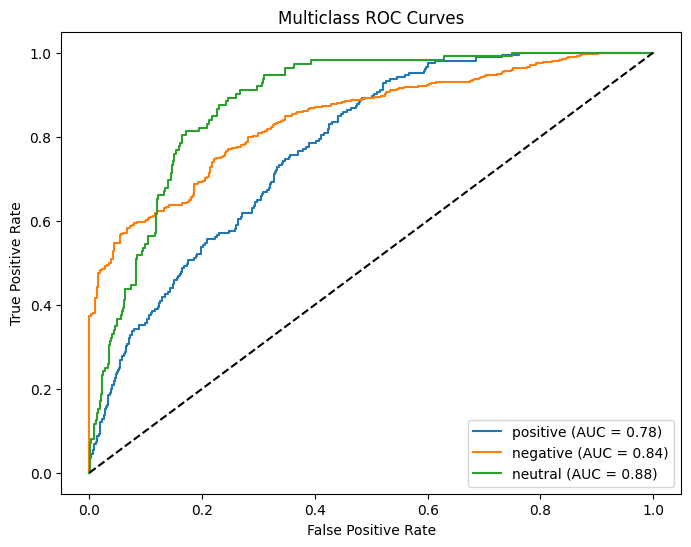

In [45]:
# Plot ROC curves for each class (multiclass)
if len(label_map) > 2:
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(label_map.keys()):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions.predictions[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], predictions.predictions[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(len(label_map)):
        plt.plot(fpr[i], tpr[i], label=f'{list(label_map.keys())[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend()
    plt.show()

In [36]:
# import json

# metrics = {
#     'accuracy': accuracy_score(true_labels, preds),
#     'weighted_f1': f1_score(true_labels, preds, average='weighted'),
#     'macro_f1': f1_score(true_labels, preds, average='macro'),
#     'roc_auc': roc_auc_score(y_true_bin, predictions.predictions, multi_class='ovr')
# }

# with open('metrics.json', 'w') as f:
#     json.dump(metrics, f, indent=4)

In [46]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/MyDrive/AfroXLMR-Sesotho")
tokenizer.save_pretrained("/content/drive/MyDrive/AfroXLMR-Sesotho")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/AfroXLMR-Sesotho/tokenizer_config.json',
 '/content/drive/MyDrive/AfroXLMR-Sesotho/special_tokens_map.json',
 '/content/drive/MyDrive/AfroXLMR-Sesotho/sentencepiece.bpe.model',
 '/content/drive/MyDrive/AfroXLMR-Sesotho/added_tokens.json',
 '/content/drive/MyDrive/AfroXLMR-Sesotho/tokenizer.json')

TF-IDF + Logistic Regression

In [47]:
X = sesotho_df['cleaned_sent']
y = sesotho_df['label']

# Split data (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [48]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [49]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [50]:
y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4258    0.5142    0.4658       212
           1     0.8799    0.7293    0.7975       713
           2     0.4051    0.6752    0.5064       117

    accuracy                         0.6795      1042
   macro avg     0.5703    0.6396    0.5899      1042
weighted avg     0.7342    0.6795    0.6974      1042



In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Train model
tfidf_model = LogisticRegression()
tfidf_model.fit(X_train_tfidf, y_train)

# Make predictions
tfidf_preds = tfidf_model.predict(X_test_tfidf)

In [52]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# F1 scores from classification reports
tfidf_f1 = classification_report(y_test, tfidf_preds, output_dict=True)
transformer_f1 = classification_report(y_test, preds, output_dict=True)

# Get weighted average F1 for each
f1_tfidf = tfidf_f1["weighted avg"]["f1-score"]
f1_transformer = transformer_f1["weighted avg"]["f1-score"]

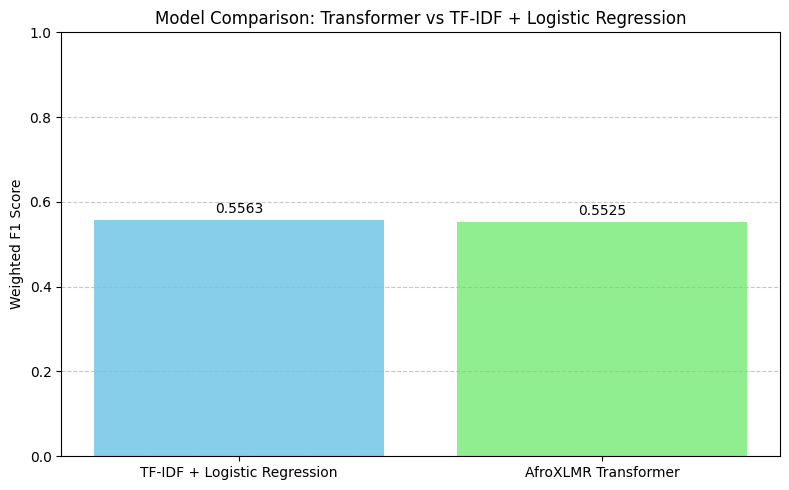

In [53]:
# Labels and scores
models = ['TF-IDF + Logistic Regression', 'AfroXLMR Transformer']
scores = [f1_tfidf, f1_transformer]

# Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Weighted F1 Score')
plt.title('Model Comparison: Transformer vs TF-IDF + Logistic Regression')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [55]:
from google.colab import drive
drive.mount('/content/drive')

tfidf_model.save("/content/drive/MyDrive/TFIDF-model")
tokenizer.save("/content/drive/MyDrive/TFIDF-model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AttributeError: 'LogisticRegression' object has no attribute 'save'